# Notebook to show how to generate synthetic networks by using the proposed benchmark

In [1]:
import matplotlib.pyplot as plt
import numpy as np

In [2]:
def calculate_permutation(u_infer: np.ndarray, u_gt: np.ndarray) -> np.ndarray:
    """
    Permuting the overlap matrix so that the groups from the two partitions correspond
    U0 has dimension NxK, reference membership
    """

    N, RANK = u_gt.shape
    M = np.dot(np.transpose(u_infer), u_gt) / N  # dim=RANKxRANK
    rows = np.zeros(RANK)
    columns = np.zeros(RANK)
    P = np.zeros((RANK, RANK))  # Permutation matrix
    for t in range(RANK):
        # Find the max element in the remaining submatrix,
        # the one with rows and columns removed from previous iterations
        max_entry = 0.0
        c_index = 0
        r_index = 0
        for i in range(RANK):
            if columns[i] == 0:
                for j in range(RANK):
                    if rows[j] == 0:
                        if M[j, i] > max_entry:
                            max_entry = M[j, i]
                            c_index = i
                            r_index = j
        if max_entry > 0:
            P[r_index, c_index] = 1
            columns[c_index] = 1
            rows[r_index] = 1
    if (np.sum(P, axis=1) == 0).any():
        row = np.where(np.sum(P, axis=1) == 0)[0]
        if (np.sum(P, axis=0) == 0).any():
            col = np.where(np.sum(P, axis=0) == 0)[0]
            P[row, col] = 1
    return P

#### Generate synthetic

In [4]:
N = 200  # number of nodes
K = 3  # number of communities
avg_degree = 25  # average degree
structure = "disassortative"
directed = False
perc_overlapping = 0.1
correlation_u_v = 1.0

out_folder = "outputs/"
output_data = False
show_details = True
show_plots = True

/home/dtheuerkauf/software-workshop/prob-gen-model-for-nets/pgm/synthetic/syn_mtcov.py:308: UserWarning: is_sparse parameter was not set. Defaulting to is_sparse=True
  warnings.warn(msg)
/home/dtheuerkauf/software-workshop/prob-gen-model-for-nets/pgm/synthetic/syn_mtcov.py:316: UserWarning: label parameter was not set. Defaulting to label=_N_L_K_avgdegree_seed
  warnings.warn(msg)
/home/dtheuerkauf/software-workshop/prob-gen-model-for-nets/pgm/synthetic/syn_mtcov.py:354: UserWarning: alpha parameter of Dirichlet distribution was not set. Defaulting to alpha=[0.1, 0.1, 0.1]
  warnings.warn(msg)


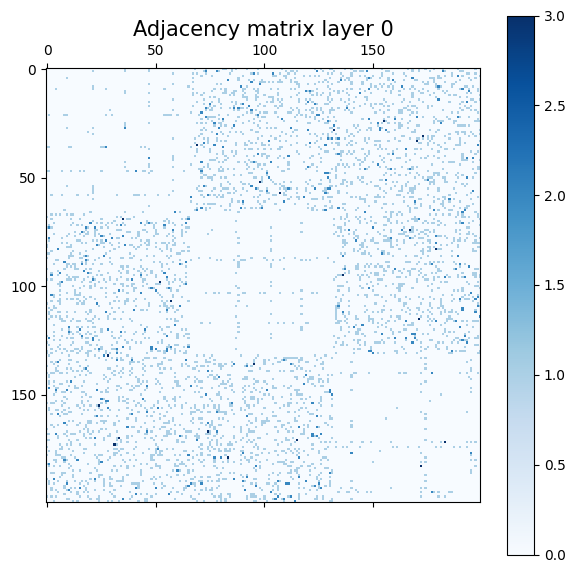

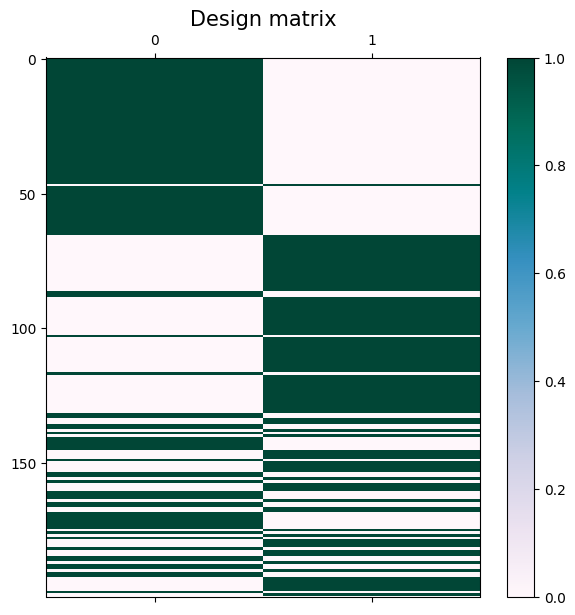

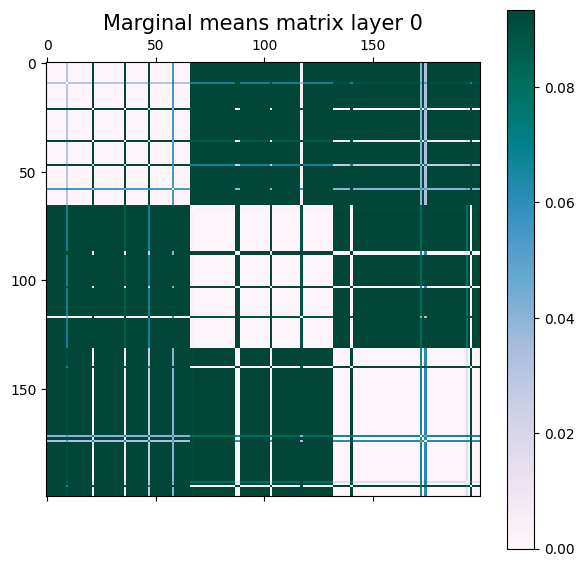

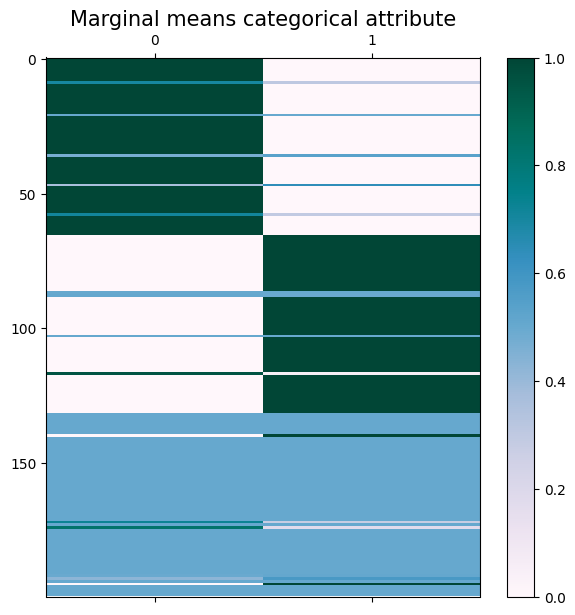

In [5]:
from pgm.synthetic import syn_mtcov

syn = syn_mtcov.SyntheticMTCOV(
    N=N,
    K=K,
    avg_degree=avg_degree,
    directed=directed,
    out_folder=out_folder,
    perc_overlapping=perc_overlapping,
    correlation_u_v=correlation_u_v,
    output_data=output_data,
    show_details=show_details,
    show_plots=show_plots,
    structure=structure,
)

#### Analyse results

In [13]:
syn.G[0] 
from pgm.input.stats import print_graph_stat
# Import the logging module
import logging

# Get the root logger and set its level to INFO
logging.getLogger().setLevel(logging.INFO)
print_graph_stat(syn.G)

INFO:root:Number of nodes = 200
INFO:root:Number of layers = 1
INFO:root:Number of edges and average degree in each layer:
INFO:root:E[0] = 2244 / <k> = 22.44
INFO:root:M[0] = 2446 - <k_weighted> = 24.460
INFO:root:Sparsity [0] = 0.056
INFO:root:Reciprocity (networkX) = 0.000


In [6]:
theta_gt = np.load("../data/input/gt_200_1_3_25_10.npz")

In [7]:
theta_inf = np.load("../data/output/theta_200_1_3_25_10.npz")

FileNotFoundError: [Errno 2] No such file or directory: '../data/output/theta_200_1_3_25_10.npz'

In [8]:
np.array_equal(theta_inf["u"], theta_inf["v"])

NameError: name 'theta_inf' is not defined

In [8]:
P = {par: calculate_permutation(theta_inf[par], theta_gt[par]) for par in ["u", "v"]}
idx_u = np.argsort(np.where(P["u"])[1])
idx_v = np.argsort(np.where(P["v"])[1])

In [9]:
P

{'u': array([[0., 1., 0.],
        [1., 0., 0.],
        [0., 0., 1.]]),
 'v': array([[0., 1., 0.],
        [1., 0., 0.],
        [0., 0., 1.]])}

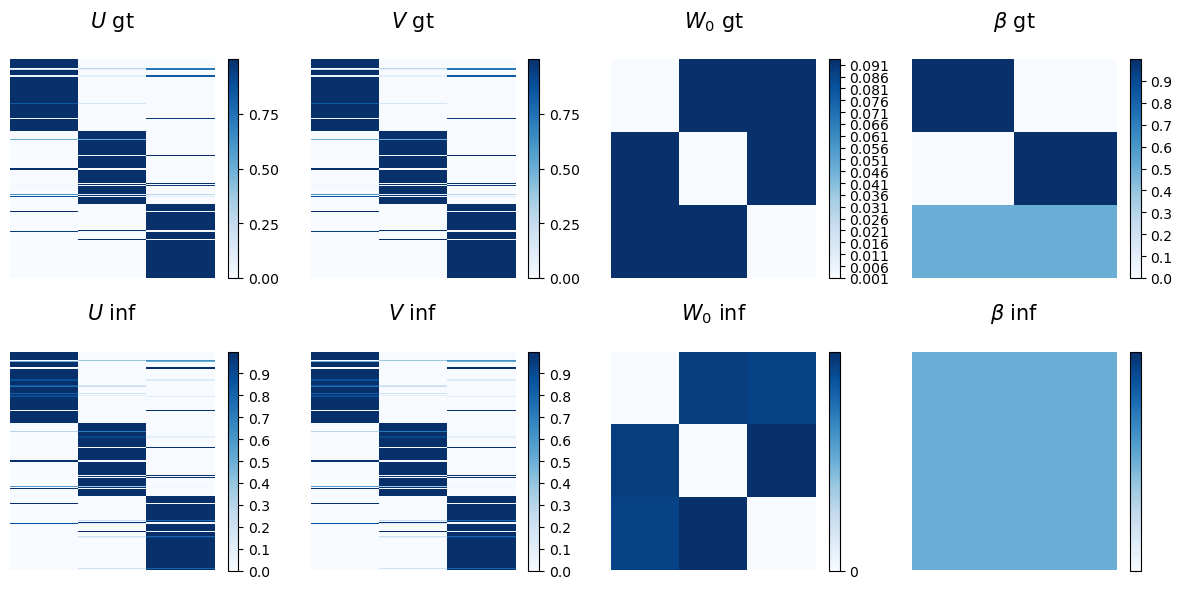

In [10]:
# plot u, v

fig, ax = plt.subplots(2, 4, figsize=(12, 6))

for col, par in enumerate(["u", "v"]):
    plot0 = ax[0, col].matshow(theta_gt[par], aspect="auto", cmap="Blues")
    fig.colorbar(
        plot0,
        ax=ax[0, col],
        ticks=np.arange(
            np.round(np.min(theta_gt[par]), 1), np.round(np.max(theta_gt[par]), 1), 0.25
        ),
    )
    ax[0, col].axis("off")
    ax[0, col].set_title(rf"${par.upper()}$ gt", fontsize=15)

    plot1 = ax[1, col].matshow(
        np.matmul(theta_inf[par], P[par]), aspect="auto", cmap="Blues"
    )
    fig.colorbar(
        plot1,
        ax=ax[1, col],
        ticks=np.arange(
            np.round(np.min(theta_inf[par]), 1),
            np.round(np.max(theta_inf[par]), 1),
            0.1,
        ),
    )
    ax[1, col].axis("off")
    ax[1, col].set_title(rf"${par.upper()}$ inf", fontsize=15)

plot0 = ax[0, 2].matshow(theta_gt["w"][0], aspect="auto", cmap="Blues")
fig.colorbar(
    plot0,
    ax=ax[0, 2],
    ticks=np.arange(
        np.round(np.min(theta_gt["w"][0]), 3),
        np.round(np.max(theta_gt["w"][0]), 3),
        0.005,
    ),
)
ax[0, 2].axis("off")
ax[0, 2].set_title(rf"$W_{0}$ gt", fontsize=15)

plot1 = ax[1, 2].matshow(
    theta_inf["w"][0][idx_u][:, idx_v], aspect="auto", cmap="Blues"
)
fig.colorbar(
    plot1,
    ax=ax[1, 2],
    ticks=np.arange(
        np.round(np.min(theta_inf["w"][0]), 3),
        np.round(np.max(theta_inf["w"][0]), 3),
        0.5,
    ),
)
ax[1, 2].axis("off")
ax[1, 2].set_title(rf"$W_{0}$ inf", fontsize=15)

plot0 = ax[0, 3].matshow(theta_gt["beta"], aspect="auto", cmap="Blues")
fig.colorbar(
    plot0,
    ax=ax[0, 3],
    ticks=np.arange(
        np.round(np.min(theta_gt["beta"]), 3),
        np.round(np.max(theta_gt["beta"]), 3),
        0.1,
    ),
)
ax[0, 3].axis("off")
ax[0, 3].set_title(rf"$\beta$ gt", fontsize=15)

plot1 = ax[1, 3].matshow(theta_inf["beta"][idx_u], aspect="auto", cmap="Blues")
fig.colorbar(
    plot1,
    ax=ax[1, 3],
    ticks=np.arange(
        np.round(np.min(theta_inf["beta"]), 3),
        np.round(np.max(theta_inf["beta"]), 3),
        0.1,
    ),
)
ax[1, 3].axis("off")
ax[1, 3].set_title(rf"$\beta$ inf", fontsize=15)

plt.tight_layout()
plt.show()

#### Reconstruction metrics

In [11]:
def Exp_ija_matrix(u, v, w):
    if w.ndim == 2:
        M = np.einsum("ik,jk->ijk", u, v)
        M = np.einsum("ijk,ak->aij", M, w)
    else:
        M = np.einsum("ik,jq->ijkq", u, v)
        M = np.einsum("ijkq,akq->aij", M, w)

    return M

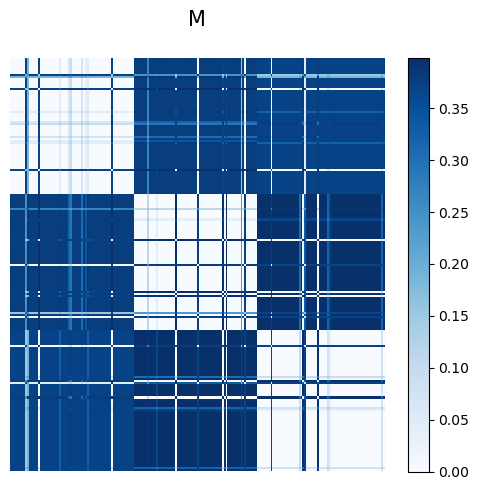

In [12]:
M = Exp_ija_matrix(theta_inf["u"], theta_inf["v"], theta_inf["w"])[0]

# plot M
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
plot0 = ax.matshow(M, aspect="auto", cmap="Blues")
fig.colorbar(
    plot0,
    ax=ax,
    ticks=np.arange(np.round(np.min(M), 1), np.round(np.max(M), 1) + 0.5, 0.05),
)
ax.axis("off")
ax.set_title("M", fontsize=15)

plt.tight_layout()
plt.show()

In [13]:
def logLoss(Y, P, eps=1e-10):

    N = Y.shape[0]

    loss = 0
    for i in range(N):
        for j in range(N):
            loss += -(
                Y[i, j] * np.log(P[i, j] + eps)
                + (1 - Y[i, j]) * np.log(1 - P[i, j] + eps)
            )

    return loss / N**2

In [14]:
print(np.round(logLoss(syn.Y[0], M), 3))

0.385


In [15]:
def absLoss(Y, P):

    N = Y.shape[0]

    loss = 0
    for i in range(N):
        for j in range(N):
            loss += Y[i, j] * np.abs(Y[i, j] - P[i, j]) + (1 - Y[i, j]) * np.abs(
                (1 - Y[i, j]) - (1 - P[i, j])
            )

    return loss / N**2

In [16]:
print(np.round(absLoss(syn.Y[0], M), 3))

0.295
